In [16]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVC
import torch, torch_geometric
import wandb
import utils
from IPython.display import clear_output
import json
import math

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

import itertools

In [17]:
def get_model_type(x):
    if isinstance(x, str) and x.startswith("1WL+NN"): return "1-WL+NN"
    elif isinstance(x, str) and (x.startswith("GAT") or x.startswith("GIN") or x.startswith("GCN")): return "GNN"
    else: return pd.NA

def get_pool_type(x):
    if isinstance(x, str) and x.endswith("Embedding-Sum"): return "Embedding:Sum"
    elif isinstance(x, str) and x.endswith("Embedding-Max"): return "Embedding:Max"
    elif isinstance(x, str) and x.endswith("Embedding-Mean"): return "Embedding:Mean"
    elif isinstance(x, str) and x.startswith("GAT") and x.endswith("Sum"): return "GAT:Sum"
    elif isinstance(x, str) and x.startswith("GAT") and x.endswith("Max"): return "GAT:Max"
    elif isinstance(x, str) and x.startswith("GAT") and x.endswith("Mean"): return "GAT:Mean"
    elif isinstance(x, str) and x.startswith("GIN") and x.endswith("Sum"): return "GIN:Sum"
    elif isinstance(x, str) and x.startswith("GIN") and x.endswith("Max"): return "GIN:Max"
    elif isinstance(x, str) and x.startswith("GIN") and x.endswith("Mean"): return "GIN:Mean"
    elif isinstance(x, str) and x.startswith("GCN") and x.endswith("Sum"): return "GCN:Sum"
    elif isinstance(x, str) and x.startswith("GCN") and x.endswith("Max"): return "GCN:Max"
    elif isinstance(x, str) and x.startswith("GCN") and x.endswith("Mean"): return "GCN:Mean"
    elif  isinstance(x, str) and x.endswith("Sum"): return "Sum"
    elif isinstance(x, str) and x.endswith("Max"): return "Max"
    elif isinstance(x, str) and x.endswith("Mean"): return "Mean"
    elif isinstance(x, str) and x.endswith("Set2Set"): return "Set2Set"
    else: return pd.NA

api = wandb.Api(timeout=30)

# Project is specified by <entity/project-name>
runs = api.runs("eric-bill/BachelorThesisExperiments")

dist_data = []
for run in runs:
    if run.state == "finished":
        dist_data.append(run.summary._json_dict | run.config | {'config' : str(run._attrs['config'])} |
                    {'Tags' : run.tags[0] if len(run.tags) > 0 else pd.NA} | {'name' : run.name, 'run_id' : run.id})

runs_df = pd.DataFrame(dist_data)
runs_df['model_type'] = runs_df['model'].apply(get_model_type)
runs_df['pool_type'] = runs_df['model'].apply(get_pool_type)
runs_df.to_csv("project.csv")

In [18]:
def get_acc_and_std(dataset, group_col, acc_col='test_accuracy', std_col='test_accuracy_std', latex=False):
    data = []

    for (grouping_name, grouping_df) in dataset.groupby(group_col):
        best_idx = grouping_df[acc_col].idxmax()
        
        if math.isnan(best_idx):
            continue
        
        acc = grouping_df.loc[best_idx, acc_col]
        std = grouping_df.loc[best_idx, std_col]
        if latex:
            result = f'{acc:.1f} \scriptsize $\pm {std:.1f}$'
        else:
            result = f"{acc:.1f} \u00B1 {std:.1f}"

        data.append({group_col[i] : grouping_name[i] for i in range(len(group_col))} |
                     {acc_col : result, 'run_id' : grouping_df.loc[best_idx, 'run_id']})
    
    return pd.DataFrame(data)

In [173]:
latex_table = get_acc_and_std(runs_df, group_col=['model_type', 'pool_type', 'dataset'], acc_col='test_accuracy', std_col='test_accuracy_std', latex=False)
latex_table = latex_table.pivot_table(index=['model_type', 'pool_type'], 
                                      columns='dataset', values=['test_accuracy'], aggfunc=lambda x: x)
latex_table

test_accuracy                                       \
dataset                         ENZYMES IMDB-BINARY        MUTAG        NCI1   
model_type pool_type                                                           
1-WL+NN    Embedding:Max     40.5 ± 7.4  69.4 ± 4.9  81.1 ± 11.2  82.7 ± 2.0   
           Embedding:Mean    42.6 ± 9.0  72.4 ± 4.1   84.1 ± 9.1  83.1 ± 1.9   
           Embedding:Sum     48.3 ± 8.1  72.0 ± 3.8   85.1 ± 8.6  83.6 ± 2.2   
           Max               16.7 ± 4.2  52.0 ± 5.3  73.8 ± 12.4  58.6 ± 3.3   
           Mean              18.2 ± 4.8  59.4 ± 5.8  77.1 ± 11.5  64.0 ± 3.3   
           Sum               18.0 ± 6.2  57.5 ± 5.1  66.8 ± 13.9  56.9 ± 3.8   
GNN        GAT:Max           31.2 ± 6.0  70.7 ± 4.8  71.1 ± 12.2  58.0 ± 4.2   
           GAT:Mean          28.9 ± 5.9  70.9 ± 3.7   74.8 ± 9.1  66.1 ± 2.8   
           GAT:Sum           34.4 ± 7.0  72.2 ± 4.5  82.1 ± 11.2  69.8 ± 2.6   
           GCN:Max           33.1 ± 7.5  73.5 ± 4.1  74.5 ± 11.3  61.1 ± 3.6   
           GCN:Mean          29.9 ± 5.7  74.7 ± 3.8  75.0 ± 10.4  68.9 ± 2.4   
           GCN:Sum           31.7 ± 7.2  73.0 ± 4.4  81.5 ± 10.3  70.4 ± 2.1   
           GIN:Max           29.2 ± 6.2  70.8 ± 4.7  77.3 ± 10.7  79.9 ± 2.2   
           GIN:Mean          31.7 ± 6.7  71.1 ± 5.4   82.4 ± 9.8  71.3 ± 2.2   
           GIN:Sum           28.9 ± 8.7  69.5 ± 4.8   84.6 ± 8.7  70.8 ± 2.3   

                                                     
dataset                      PROTEINS REDDIT-BINARY  
model_type pool_type                                 
1-WL+NN    Embedding:Max   75.2 ± 3.9    70.1 ± 2.9  
           Embedding:Mean  72.7 ± 4.6    75.4 ± 2.8  
           Embedding:Sum   75.2 ± 4.5    78.4 ± 2.7  
           Max             62.9 ± 4.9    69.2 ± 4.0  
           Mean            60.9 ± 4.5    66.1 ± 3.2  
           Sum             65.6 ± 4.8    73.0 ± 5.1  
GNN        GAT:Max         72.5 ± 5.1           NaN  
           GAT:Mean        64.9 ± 6.4           NaN  
           GAT:Sum         73.4 ± 3.9           NaN  
           GCN:Max         69.8 ± 5.9    74.3 ± 4.5  
           GCN:Mean        70.9 ± 5.2    82.3 ± 3.3  
           GCN:Sum         73.9 ± 4.0           NaN  
           GIN:Max         74.3 ± 5.1           NaN  
           GIN:Mean        72.0 ± 4.0           NaN  
           GIN:Sum         73.2 ± 4.3           NaN

In [43]:
latex_table = get_acc_and_std(runs_df, group_col=['model_type', 'dataset'], acc_col='test_accuracy', std_col='test_accuracy_std', latex=True)
latex_table = latex_table.pivot_table(index=['model_type'], 
                                      columns='dataset', values=['test_accuracy'], aggfunc=lambda x: x)
latex_table

test_accuracy                              \
dataset                        ENZYMES                 IMDB-BINARY   
model_type                                                           
1-WL+NN     48.3 \scriptsize $\pm 8.1$  72.4 \scriptsize $\pm 4.1$   
GNN         34.4 \scriptsize $\pm 7.0$  74.7 \scriptsize $\pm 3.8$   

                                                                    \
dataset                          MUTAG                        NCI1   
model_type                                                           
1-WL+NN     85.1 \scriptsize $\pm 8.6$  83.6 \scriptsize $\pm 2.2$   
GNN         84.6 \scriptsize $\pm 8.7$  79.9 \scriptsize $\pm 2.2$   

                                                                    
dataset                       PROTEINS               REDDIT-BINARY  
model_type                                                          
1-WL+NN     75.2 \scriptsize $\pm 3.9$  78.4 \scriptsize $\pm 2.7$  
GNN         74.3 \scriptsize $\pm 5.1$  82.3 \scriptsize $\pm 3.3$

In [14]:
latex_svm = get_acc_and_std(runs_df[runs_df['Tags'] == 'replicate_run'], group_col=['model_type', 'pool_type', 'dataset'],
                             acc_col='test_accuracy', std_col='test_accuracy_std')
latex_svm = latex_svm.pivot_table(index=['model_type', 'pool_type'], 
                                      columns='dataset', values=['run_id'], aggfunc=lambda x: x)
latex_svm

run_id                                
dataset                     ENZYMES IMDB-BINARY      NCI1  PROTEINS
model_type pool_type                                               
1-WL+NN    Embedding:Max   60562q4o    rrb09qm5  kr2efr0t  xwp3x7vc
           Embedding:Mean  ztju6f9s    hsoebyq6  rvfi5ksh  0wseenmc
           Embedding:Sum   o84jwl99         NaN  9c64l23v  yt6edt4n
GNN        GAT:Sum         r0hzi69w         NaN       NaN       NaN
           GCN:Max         hhc3yspq    423spwqo       NaN       NaN
           GCN:Mean             NaN    h41v1r4j       NaN       NaN
           GCN:Sum              NaN    onhuomtj       NaN  4bkmzbdv
           GIN:Max              NaN         NaN  ircwl3vt  nor2tequ
           GIN:Mean        6lezhkeo         NaN  zu2bqs8z  q0nhlr39
           GIN:Sum              NaN         NaN  l7jvcxkk       NaN

In [42]:
latex_svm = get_acc_and_std(runs_df[runs_df['Tags'] == 'replicate_run'], group_col=['model_type', 'pool_type', 'dataset'],
                             acc_col='svm_lin_accuracies', std_col='svm_lin_accuracies_std', latex=True)
latex_svm = latex_svm.pivot_table(index=['model_type', 'pool_type'], 
                                      columns='dataset', values=['svm_lin_accuracies'], aggfunc=lambda x: x)
latex_svm

svm_lin_accuracies  \
dataset                                       ENZYMES   
model_type pool_type                                    
1-WL+NN    Embedding:Max   36.9 \scriptsize $\pm 5.6$   
           Embedding:Mean  37.4 \scriptsize $\pm 6.6$   
           Embedding:Sum   34.4 \scriptsize $\pm 5.5$   
GNN        GAT:Sum         33.2 \scriptsize $\pm 5.9$   
           GCN:Max         37.3 \scriptsize $\pm 6.9$   
           GCN:Mean                               NaN   
           GCN:Sum                                NaN   
           GIN:Max                                NaN   
           GIN:Mean        29.0 \scriptsize $\pm 6.2$   
           GIN:Sum                                NaN   

                                                       \
dataset                                   IMDB-BINARY   
model_type pool_type                                    
1-WL+NN    Embedding:Max   68.9 \scriptsize $\pm 4.8$   
           Embedding:Mean  71.2 \scriptsize $\pm 3.9$   
           Embedding:Sum                          NaN   
GNN        GAT:Sum                                NaN   
           GCN:Max         73.5 \scriptsize $\pm 4.3$   
           GCN:Mean        74.4 \scriptsize $\pm 4.1$   
           GCN:Sum         74.3 \scriptsize $\pm 4.4$   
           GIN:Max                                NaN   
           GIN:Mean                               NaN   
           GIN:Sum                                NaN   

                                                        \
dataset                                          MUTAG   
model_type pool_type                                     
1-WL+NN    Embedding:Max                           NaN   
           Embedding:Mean                          NaN   
           Embedding:Sum    86.4 \scriptsize $\pm 8.9$   
GNN        GAT:Sum                                 NaN   
           GCN:Max                                 NaN   
           GCN:Mean                                NaN   
           GCN:Sum                                 NaN   
           GIN:Max                                 NaN   
           GIN:Mean                                NaN   
           GIN:Sum         51.9 \scriptsize $\pm 34.1$   

                                                       \
dataset                                          NCI1   
model_type pool_type                                    
1-WL+NN    Embedding:Max   82.9 \scriptsize $\pm 1.9$   
           Embedding:Mean  82.7 \scriptsize $\pm 1.8$   
           Embedding:Sum   83.4 \scriptsize $\pm 2.1$   
GNN        GAT:Sum                                NaN   
           GCN:Max                                NaN   
           GCN:Mean                               NaN   
           GCN:Sum                                NaN   
           GIN:Max         67.4 \scriptsize $\pm 2.2$   
           GIN:Mean        69.2 \scriptsize $\pm 2.2$   
           GIN:Sum         70.1 \scriptsize $\pm 3.1$   

                                                       
dataset                                      PROTEINS  
model_type pool_type                                   
1-WL+NN    Embedding:Max   73.9 \scriptsize $\pm 4.1$  
           Embedding:Mean  66.9 \scriptsize $\pm 4.2$  
           Embedding:Sum   74.5 \scriptsize $\pm 4.0$  
GNN        GAT:Sum                                NaN  
           GCN:Max                                NaN  
           GCN:Mean                               NaN  
           GCN:Sum         73.8 \scriptsize $\pm 4.2$  
           GIN:Max         74.7 \scriptsize $\pm 4.2$  
           GIN:Mean        67.7 \scriptsize $\pm 4.4$  
           GIN:Sum                                NaN

In [41]:
latex_rbf = get_acc_and_std(runs_df[runs_df['Tags'] == 'replicate_run'], group_col=['model_type', 'pool_type', 'dataset'],
                             acc_col='svm_rbf_accuracies', std_col='svm_rbf_accuracies_std', latex=True)
latex_rbf = latex_rbf.pivot_table(index=['model_type', 'pool_type'], 
                                      columns='dataset', values=['svm_rbf_accuracies'], aggfunc=lambda x: x)
latex_rbf

svm_rbf_accuracies  \
dataset                                       ENZYMES   
model_type pool_type                                    
1-WL+NN    Embedding:Max   41.2 \scriptsize $\pm 5.8$   
           Embedding:Mean  43.4 \scriptsize $\pm 7.0$   
           Embedding:Sum   45.0 \scriptsize $\pm 7.0$   
GNN        GAT:Sum         35.9 \scriptsize $\pm 6.0$   
           GCN:Max         28.5 \scriptsize $\pm 5.7$   
           GCN:Mean                               NaN   
           GCN:Sum                                NaN   
           GIN:Max                                NaN   
           GIN:Mean        29.4 \scriptsize $\pm 5.9$   
           GIN:Sum                                NaN   

                                                       \
dataset                                   IMDB-BINARY   
model_type pool_type                                    
1-WL+NN    Embedding:Max   69.2 \scriptsize $\pm 5.0$   
           Embedding:Mean  72.8 \scriptsize $\pm 4.3$   
           Embedding:Sum                          NaN   
GNN        GAT:Sum                                NaN   
           GCN:Max         73.0 \scriptsize $\pm 4.2$   
           GCN:Mean        74.6 \scriptsize $\pm 4.6$   
           GCN:Sum         73.6 \scriptsize $\pm 4.1$   
           GIN:Max                                NaN   
           GIN:Mean                               NaN   
           GIN:Sum                                NaN   

                                                       \
dataset                                         MUTAG   
model_type pool_type                                    
1-WL+NN    Embedding:Max                          NaN   
           Embedding:Mean                         NaN   
           Embedding:Sum   83.2 \scriptsize $\pm 7.5$   
GNN        GAT:Sum                                NaN   
           GCN:Max                                NaN   
           GCN:Mean                               NaN   
           GCN:Sum                                NaN   
           GIN:Max                                NaN   
           GIN:Mean                               NaN   
           GIN:Sum         86.0 \scriptsize $\pm 7.4$   

                                                       \
dataset                                          NCI1   
model_type pool_type                                    
1-WL+NN    Embedding:Max   83.1 \scriptsize $\pm 2.0$   
           Embedding:Mean  83.4 \scriptsize $\pm 1.9$   
           Embedding:Sum   83.6 \scriptsize $\pm 1.9$   
GNN        GAT:Sum                                NaN   
           GCN:Max                                NaN   
           GCN:Mean                               NaN   
           GCN:Sum                                NaN   
           GIN:Max         73.0 \scriptsize $\pm 1.9$   
           GIN:Mean        70.2 \scriptsize $\pm 2.0$   
           GIN:Sum         70.9 \scriptsize $\pm 2.3$   

                                                       
dataset                                      PROTEINS  
model_type pool_type                                   
1-WL+NN    Embedding:Max   75.2 \scriptsize $\pm 4.0$  
           Embedding:Mean  73.7 \scriptsize $\pm 4.6$  
           Embedding:Sum   74.5 \scriptsize $\pm 3.8$  
GNN        GAT:Sum                                NaN  
           GCN:Max                                NaN  
           GCN:Mean                               NaN  
           GCN:Sum         73.3 \scriptsize $\pm 4.6$  
           GIN:Max         74.6 \scriptsize $\pm 4.6$  
           GIN:Mean        71.5 \scriptsize $\pm 4.2$  
           GIN:Sum                                NaN

In [10]:
latex_table

test_accuracy                              \
dataset                         ENZYMES   IMDB-BINARY          NCI1   
model_type pool_type                                                  
1-WL+NN    Embedding:Max   40.50 ± 7.36  69.38 ± 4.90  82.59 ± 1.88   
           Embedding:Mean  42.60 ± 9.02  72.40 ± 4.06  82.92 ± 2.03   
           Embedding:Sum   48.27 ± 8.11  72.00 ± 3.84  83.60 ± 2.18   
           Max                      NaN  51.62 ± 5.01  58.55 ± 3.27   
           Mean                     NaN  58.46 ± 6.59  63.97 ± 3.23   
           Sum             17.27 ± 4.63  56.12 ± 6.12  54.49 ± 3.24   
GNN        Max             33.07 ± 7.46  73.52 ± 4.10  79.63 ± 2.24   
           Mean            31.73 ± 6.70  74.68 ± 3.84  70.76 ± 2.16   
           Sum             34.40 ± 7.00  72.90 ± 3.83  70.84 ± 2.32   

                                         
dataset                        PROTEINS  
model_type pool_type                     
1-WL+NN    Embedding:Max   75.20 ± 3.92  
           Embedding:Mean  72.32 ± 4.19  
           Embedding:Sum   75.18 ± 4.46  
           Max             62.90 ± 4.93  
           Mean            60.89 ± 4.69  
           Sum             65.44 ± 4.80  
GNN        Max             74.28 ± 5.07  
           Mean            71.96 ± 4.04  
           Sum             73.45 ± 3.92

In [11]:
latex_svm

svm_lin_accuracies              
dataset                              ENZYMES   IMDB-BINARY
model_type pool_type                                      
1-WL+NN    Embedding:Max        36.93 ± 5.65  68.94 ± 4.78
           Embedding:Mean       37.37 ± 6.60  71.24 ± 3.93
           Embedding:Sum        34.37 ± 5.47           NaN
GNN        Max                  37.30 ± 6.91           NaN
           Mean                 29.00 ± 6.22           NaN

# Distance Matrix

In [350]:
from torch_geometric.utils import degree
from utils import NormalizedDegree
import torch_geometric.transforms as T

dataset_name = 'NCI1'

model_gnn = torch.load(f'saved_models/GNN_{dataset_name}.pt')
model_wlnn = torch.load(f'saved_models/WLNN_{dataset_name}.pt')

dataset = model_gnn.dataset
train_index, test_index = model_gnn.train_index, model_gnn.test_index
agg_data = model_gnn.data_aggregate

In [351]:
model_wlnn.config['k_wl']

3

In [352]:
from utils import Wrapper_WL_TUDataset, Constant_Long

if dataset._data.x is None:
    print('No node features found. Using constant function for 1WL+NN.')
    dataset.transform = Constant_Long(0)

wl_dataset = Wrapper_WL_TUDataset(dataset, k_wl=model_wlnn.config['k_wl'], wl_convergence=False)

In [353]:
if dataset._data.x is None:
    print('No node features found. Using one-hot degree for GNNs.')
    max_degree = 0
    degs = []
    for data in dataset:
        degs += [degree(data.edge_index[0], dtype=torch.long)]
        max_degree = max(max_degree, degs[-1].max().item())

    if max_degree < 1000:
        dataset.transform = T.OneHotDegree(max_degree)
    else:
        deg = torch.cat(degs, dim=0).to(torch.float)
        mean, std = deg.mean().item(), deg.std().item()
        dataset.transform = NormalizedDegree(mean, std)

In [354]:
# Sample 10 random graphs from the test set
indices_graphs = torch.randint(0, len(test_index), (10,))
indices_graphs = test_index[indices_graphs]
single_index = test_index[0]

global_error_mean = 0.0
global_error_std = 0.0
df_dist_matrix = pd.DataFrame()
df_tsne = pd.DataFrame()

with torch.no_grad():
    for idx in test_index:
        num_nodes = dataset[idx].num_nodes
        x_gnn = model_gnn.gnn(dataset[idx].x, dataset[idx].edge_index)
        x_wl = wl_dataset[idx].x

        # Calculate distance matrix
        distance_matrix_gnn = torch.cdist(x_gnn, x_gnn, p=2)
        distance_matrix_gnn = distance_matrix_gnn / distance_matrix_gnn.max() if distance_matrix_gnn.max() > 0 else distance_matrix_gnn
        distance_matrix_wl = torch.sign((x_wl.unsqueeze(1) - x_wl)**2)

        dist_data = pd.DataFrame(list(itertools.product(['GNN Node Representations', '1-WL Colors'], range(0, num_nodes), range(0, num_nodes))), columns=['type', 'i', 'j'])
        dist_data['distance'] = torch.cat([distance_matrix_gnn.flatten(), distance_matrix_wl.flatten()], dim=0).numpy()
        dist_data['idx'] = idx.item()

        error_matrix = (distance_matrix_gnn - distance_matrix_wl).abs()
        dist_data['normed_error'] = f"Graph Index: {idx}\nMAE: {round(error_matrix.mean().item(), 2)} ± {round(error_matrix.std().item(), 2)}"
        global_error_mean += error_matrix.mean().item()
        global_error_std += error_matrix.std().item()


        df_dist_matrix = pd.concat([df_dist_matrix, dist_data], axis=0, ignore_index=True)

print(f'Global normed error: {round(global_error_mean / len(test_index), 2)} ± {round(global_error_std / len(test_index), 2)}')

Global normed error: 0.5 ± 0.24


/opt/homebrew/Caskroom/miniconda/base/envs/pyg-m1/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._figure.tight_layout(*args, **kwargs)


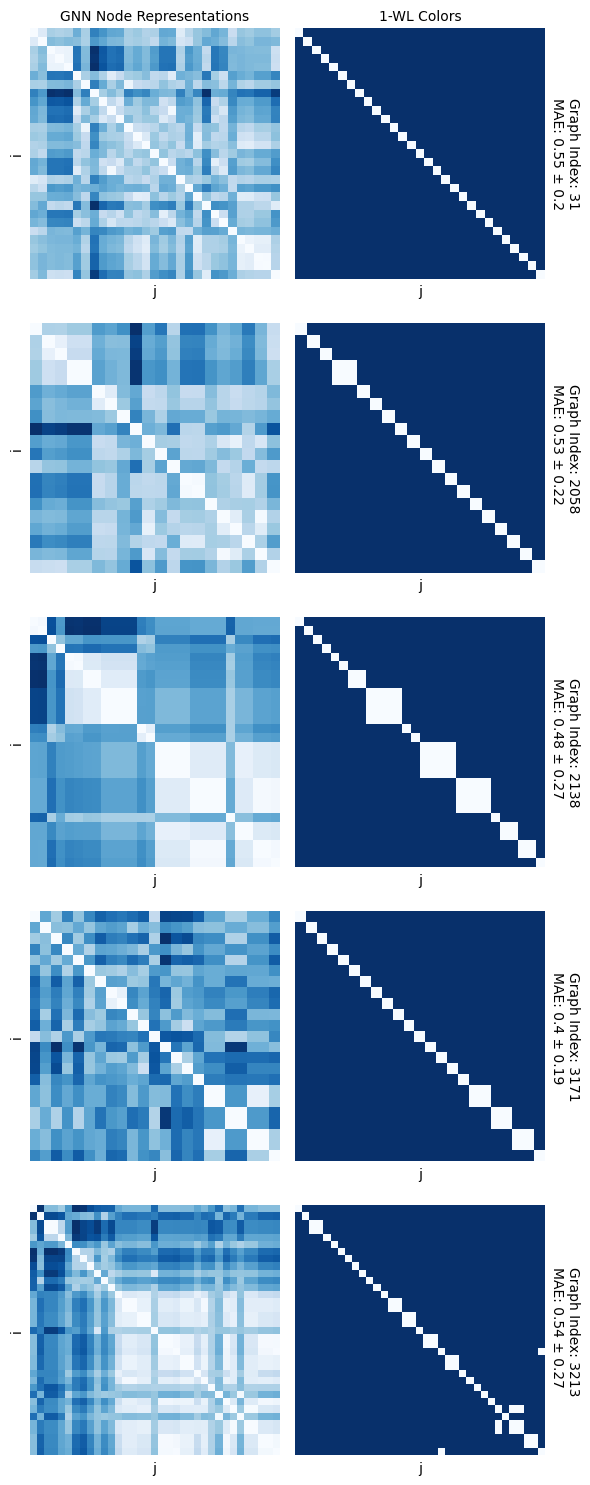

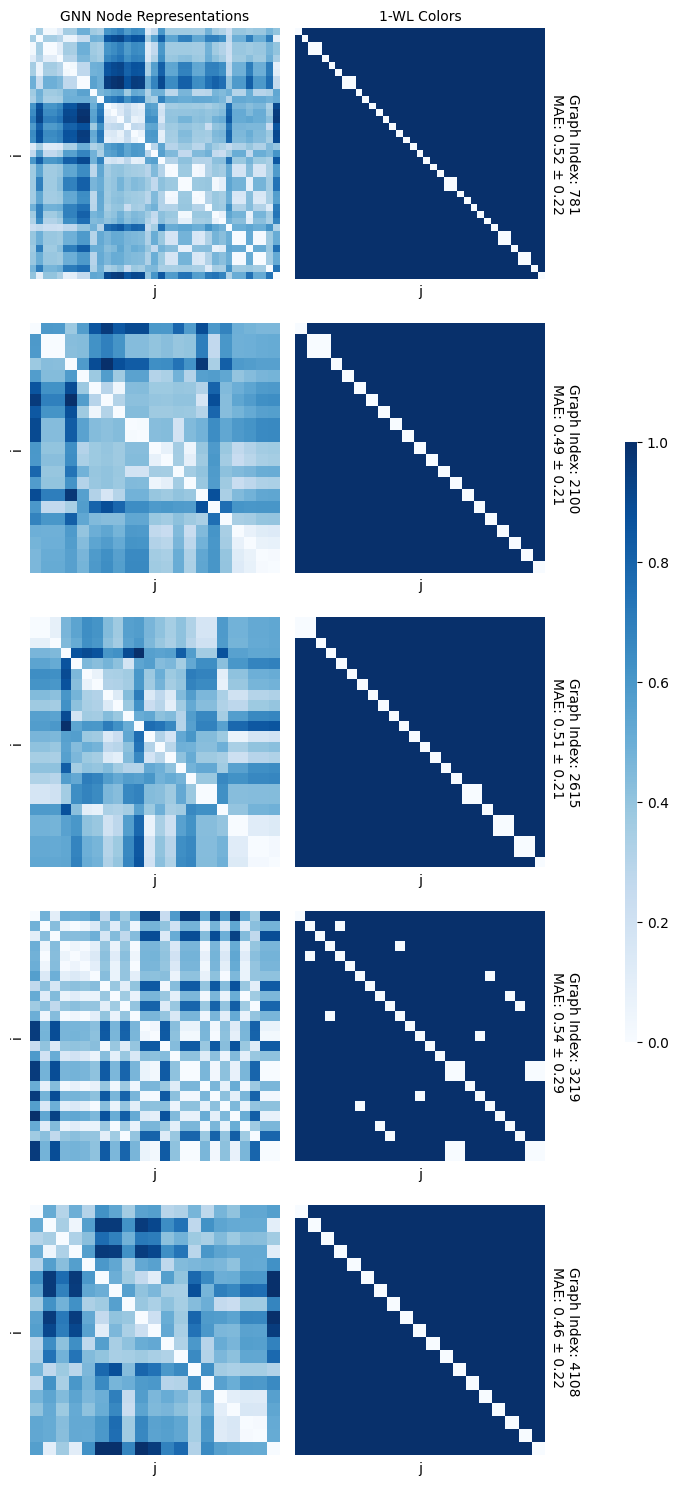

In [355]:
def facet_heatmap(data, color, **kwargs):
    data = data.pivot(index="i", columns='j', values='distance')
    sns.heatmap(data, cmap='Blues', **kwargs)

index_split = [indices_graphs[:5], indices_graphs[5:]]
for i in range(2):
    data = df_dist_matrix[df_dist_matrix['idx'].isin(index_split[i])]
    g = sns.FacetGrid(data, col='type', row='normed_error', sharex='row', sharey='row', margin_titles=True)

    if i == 0:
        g.map_dataframe(facet_heatmap, cbar=False, vmin=0, vmax=1, square=True, xticklabels=False, yticklabels=False)
    else:
        cbar_ax = g.fig.add_axes([1.05, .3, .02, .4])  # <-- Create a colorbar axes
        g.map_dataframe(facet_heatmap, cbar_ax=cbar_ax, vmin=0, vmax=1, square=True, xticklabels=False, yticklabels=False)

    g.set_titles(row_template="{row_name}", col_template="{col_name}")
    
    #g.savefig(f'../Latex/Figures/heatmaps_{dataset.name}_{i}.pdf'.format(i), bbox_inches='tight')

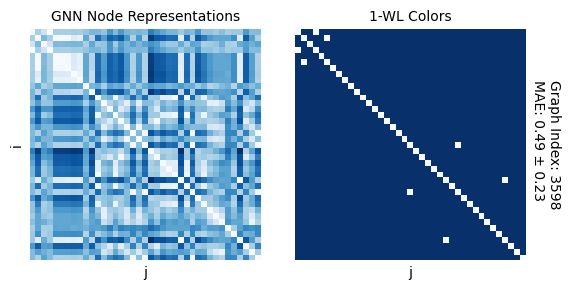

In [365]:
data = df_dist_matrix[df_dist_matrix['idx'] == test_index[torch.randint(0, len(test_index), (1,)).item()]]
g = sns.FacetGrid(data, col='type', row='normed_error', sharex='row', sharey='row', margin_titles=True)
g.map_dataframe(facet_heatmap, cbar=False, vmin=0, vmax=1, square=True, xticklabels=False, yticklabels=False)
g.set_titles(row_template="{row_name}", col_template="{col_name}")
g.savefig(f'../Latex/Figures/heatmaps_{dataset.name}_single.pdf', bbox_inches='tight')

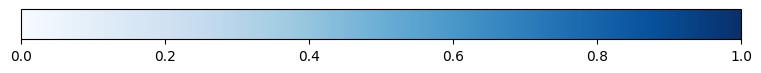

In [378]:
import pylab as pl
import numpy as np

a = np.array([[0,1]])
pl.figure(figsize=(9, 0.5))
img = pl.imshow(a, cmap="Blues")
pl.gca().set_visible(False)
cax = pl.axes([0.1, 0.2, 0.8, 0.6])
pl.colorbar(orientation="horizontal", cax=cax)
#pl.savefig("../Latex/Figures/colorbar.pdf", bbox_inches='tight')

# Clustering Metric

In [1]:
from sklearn import metrics

all_metrics = ['rand_score', 'adjusted_rand_score', 'normalized_mutual_info_score', 'adjusted_mutual_info_score',
               'homogeneity_score', 'completeness_score', 'v_measure_score', 'fowlkes_mallows_score']
def evaluate(y_pred, y_true):
    rs = metrics.rand_score(y_true, y_pred)
    ars = metrics.adjusted_rand_score(y_true, y_pred)
    nmi = metrics.normalized_mutual_info_score(y_true, y_pred)
    ami = metrics.adjusted_mutual_info_score(y_true, y_pred)
    hom = metrics.homogeneity_score(y_true, y_pred)
    com = metrics.completeness_score(y_true, y_pred)
    vms = metrics.v_measure_score(y_true, y_pred)
    fws = metrics.fowlkes_mallows_score(y_true, y_pred)


    return {'rand_score': rs, 'adjusted_rand_score': ars, 'normalized_mutual_info_score': nmi,
            'adjusted_mutual_info_score': ami, 'homogeneity_score': hom, 'completeness_score': com,
            'v_measure_score': vms, 'fowlkes_mallows_score': fws}

In [14]:
with torch.no_grad():
    x_train = []
    y_train = []

    for idx in train_index:
        x_gnn = model.gnn(dataset[idx].x, dataset[idx].edge_index)
        x_wl = wl_dataset[idx].x

        x_train.append(x_gnn)
        y_train.append(x_wl)

    x_train = torch.cat(x_train, dim=0)
    y_train = torch.cat(y_train, dim=0)

    x_test = []
    y_test = []

    for idx in test_index:
        x_gnn = model.gnn(dataset[idx].x, dataset[idx].edge_index)
        x_wl = wl_dataset[idx].x

        x_test.append(x_gnn)
        y_test.append(x_wl)

    x_test = torch.cat(x_test, dim=0)
    y_test = torch.cat(y_test, dim=0)

In [14]:
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN, OPTICS, Birch, BisectingKMeans
dist_data = []
num_cluster = len(torch.unique(y_test))

kmeans = KMeans(n_clusters=num_cluster, random_state=42, init='k-means++', n_init='auto').fit(x_test)
dist_data.append(evaluate(kmeans.labels_, y_test) | {'name': 'kmeans', 'num_cluster': num_cluster})

aggC_ward = AgglomerativeClustering(n_clusters=num_cluster, linkage='ward').fit(x_test)
dist_data.append(evaluate(aggC_ward.labels_, y_test) | {'name': 'aggC_ward', 'num_cluster': num_cluster})

aggC_avg = AgglomerativeClustering(n_clusters=num_cluster, linkage='average').fit(x_test)
dist_data.append(evaluate(aggC_avg.labels_, y_test) | {'name': 'aggC_avg', 'num_cluster': num_cluster})

dbscan = DBSCAN(eps=0.5, min_samples=5).fit(x_test)
dist_data.append(evaluate(dbscan.labels_, y_test) | {'name': 'dbscan', 'num_cluster': num_cluster})

optics = OPTICS(min_samples=5).fit(x_test)
dist_data.append(evaluate(optics.labels_, y_test) | {'name': 'optics', 'num_cluster': num_cluster})

birch = Birch(n_clusters=num_cluster).fit(x_test)
dist_data.append(evaluate(birch.labels_, y_test) | {'name': 'birch', 'num_cluster': num_cluster})

bisectingKmeans = BisectingKMeans(n_clusters=num_cluster).fit(x_test)
dist_data.append(evaluate(bisectingKmeans.labels_, y_test) | {'name': 'bisectingKmeans', 'num_cluster': num_cluster})

df_cluster_metrics = pd.DataFrame(dist_data)

In [19]:
df_cluster_metrics

,rand_score,adjusted_rand_score,normalized_mutual_info_score,adjusted_mutual_info_score,homogeneity_score,completeness_score,v_measure_score,fowlkes_mallows_score,name,num_cluster
0,0.966394,0.297932,0.687398,0.613401,0.780458,0.614167,0.687398,0.367233,kmeans,149
1,0.966792,0.292508,0.710801,0.640931,0.812982,0.631438,0.710801,0.369268,aggC_ward,149
2,0.948761,0.340135,0.653657,0.592979,0.655570,0.651755,0.653657,0.367724,aggC_avg,149
3,0.209294,0.014530,0.146240,0.130254,0.080907,0.759746,0.146240,0.208999,dbscan,149
4,0.635521,-0.000065,0.423289,0.258958,0.374406,0.486854,0.423289,0.114880,optics,149
5,0.955879,0.296869,0.617139,0.546602,0.641659,0.594424,0.617139,0.322979,birch,149
6,0.964425,0.242018,0.651642,0.568485,0.743872,0.579759,0.651642,0.308943,bisectingKmeans,149


In [37]:
with torch.no_grad():
    x_train = []
    y_train = []

    for idx in train_index:
        x_gnn = model.gnn(dataset[idx].x, dataset[idx].edge_index)
        x_gnn = model.pool(x_gnn, dataset[idx].batch)
        x_wl = dataset[idx].y

        x_train.append(x_gnn)
        y_train.append(x_wl)

    x_train = torch.cat(x_train, dim=0)
    y_train = torch.cat(y_train, dim=0)

    x_test = []
    y_test = []

    for idx in test_index:
        x_gnn = model.gnn(dataset[idx].x, dataset[idx].edge_index)
        x_gnn = model.pool(x_gnn, dataset[idx].batch)
        x_wl = dataset[idx].y

        x_test.append(x_gnn)
        y_test.append(x_wl)

    x_test = torch.cat(x_test, dim=0)
    y_test = torch.cat(y_test, dim=0)

# KNN

In [21]:
knn_runs = ['o84jwl99', 'r0hzi69w', 'hsoebyq6', 'h41v1r4j', '9c64l23v', 'ircwl3vt', 'xwp3x7vc', 'nor2tequ', 'vvw0t1se', 'tku7invn']

df_knn = pd.DataFrame()
api = wandb.Api()
runs = api.runs("eric-bill/BachelorThesisExperiments")

for run in runs:
    if run.state == "finished" and run.id in knn_runs:

        knn = run.history(keys=['k', 'knn_accuracies', 'knn_accuracies_std'])
        knn['dataset'] = run.config['dataset']
        knn['model_type'] = get_model_type(run.config['model'])
        knn['test_accuracy'] = run.summary['test_accuracy']
        knn['run_id'] = run.id

        df_knn = pd.concat([df_knn, knn], ignore_index=True)

df_knn

,_step,k,knn_accuracies,knn_accuracies_std,dataset,model_type,test_accuracy,run_id
0,0,1,85.742690,7.896076,MUTAG,GNN,83.350876,tku7invn
1,1,2,81.923977,9.387200,MUTAG,GNN,83.350876,tku7invn
2,2,3,83.988304,8.453578,MUTAG,GNN,83.350876,tku7invn
3,3,4,84.508772,7.569330,MUTAG,GNN,83.350876,tku7invn
4,4,5,85.035088,7.356859,MUTAG,GNN,83.350876,tku7invn
...,...,...,...,...,...,...,...,...
1895,195,196,25.800000,5.283783,ENZYMES,1-WL+NN,47.866665,o84jwl99
1896,196,197,25.466667,5.281637,ENZYMES,1-WL+NN,47.866665,o84jwl99
1897,197,198,25.633333,5.280027,ENZYMES,1-WL+NN,47.866665,o84jwl99
1898,198,199,25.366667,5.576615,ENZYMES,1-WL+NN,47.866665,o84jwl99


In [44]:
pivot_knn = get_acc_and_std(df_knn, group_col=['model_type','dataset'], acc_col='knn_accuracies', std_col='k', latex=False)
pivot_knn.pivot_table(index=['model_type'], columns=['dataset'], values=['knn_accuracies'], aggfunc=lambda x: x)

knn_accuracies                                                    
dataset           ENZYMES   IMDB-BINARY        MUTAG        NCI1     PROTEINS
model_type                                                                   
1-WL+NN        56.3 ± 1.0   72.3 ± 11.0  86.7 ± 10.0  83.9 ± 5.0  73.9 ± 19.0
GNN            51.6 ± 1.0  74.3 ± 132.0  88.3 ± 38.0  77.5 ± 2.0  74.9 ± 27.0

In [160]:
df_knn[df_knn['dataset'] == 'MUTAG']

,_step,k,knn_accuracies,knn_accuracies_std,dataset,model_type,test_accuracy,run_id
0,0,1,85.742690,7.896076,MUTAG,GNN,83.350876,tku7invn
1,1,2,81.923977,9.387200,MUTAG,GNN,83.350876,tku7invn
2,2,3,83.988304,8.453578,MUTAG,GNN,83.350876,tku7invn
3,3,4,84.508772,7.569330,MUTAG,GNN,83.350876,tku7invn
4,4,5,85.035088,7.356859,MUTAG,GNN,83.350876,tku7invn
...,...,...,...,...,...,...,...,...
1895,195,196,25.800000,5.283783,ENZYMES,1-WL+NN,47.866665,o84jwl99
1896,196,197,25.466667,5.281637,ENZYMES,1-WL+NN,47.866665,o84jwl99
1897,197,198,25.633333,5.280027,ENZYMES,1-WL+NN,47.866665,o84jwl99
1898,198,199,25.366667,5.576615,ENZYMES,1-WL+NN,47.866665,o84jwl99


/var/folders/gk/0jn5z2112g5b638tcpy_xs980000gn/T/ipykernel_1709/3652420221.py:22: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.axes[0].set_yticklabels([f'{int(y) if y.is_integer() else y}%' for y in g.axes[0].get_yticks()])


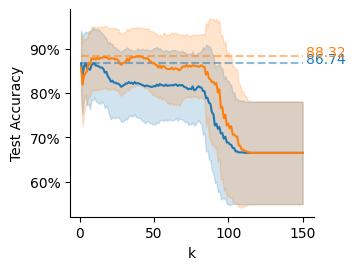

/var/folders/gk/0jn5z2112g5b638tcpy_xs980000gn/T/ipykernel_1709/3652420221.py:22: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.axes[0].set_yticklabels([f'{int(y) if y.is_integer() else y}%' for y in g.axes[0].get_yticks()])


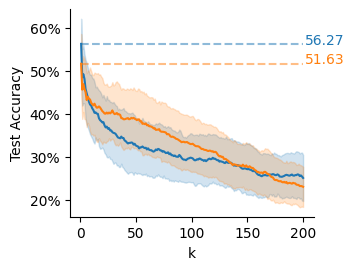

/var/folders/gk/0jn5z2112g5b638tcpy_xs980000gn/T/ipykernel_1709/3652420221.py:22: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.axes[0].set_yticklabels([f'{int(y) if y.is_integer() else y}%' for y in g.axes[0].get_yticks()])


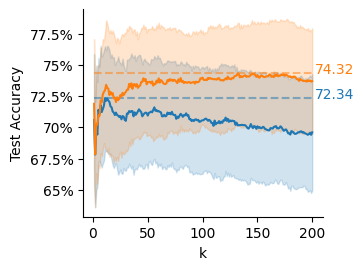

/var/folders/gk/0jn5z2112g5b638tcpy_xs980000gn/T/ipykernel_1709/3652420221.py:22: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.axes[0].set_yticklabels([f'{int(y) if y.is_integer() else y}%' for y in g.axes[0].get_yticks()])


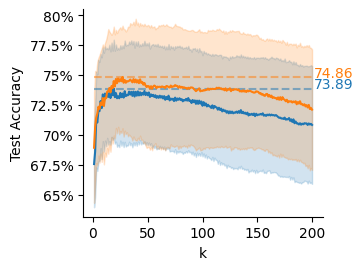

/var/folders/gk/0jn5z2112g5b638tcpy_xs980000gn/T/ipykernel_1709/3652420221.py:22: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.axes[0].set_yticklabels([f'{int(y) if y.is_integer() else y}%' for y in g.axes[0].get_yticks()])


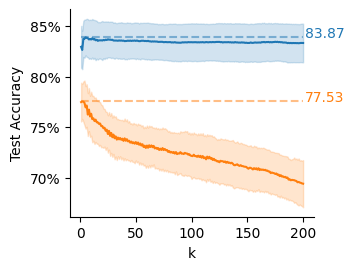

In [171]:
def plot_knn(data, x, y, std, **kwargs):
    y_max = data[y].max()
    data_max = pd.DataFrame({'max': [y_max] * len(data), x: data[x]})
    sns.lineplot(data_max, x=x, y='max', color=kwargs['color'], alpha=0.5, linestyle='--')

    line = sns.lineplot(data=data, x=x, y=y, **kwargs)
    line.axes.text(data[x].max() + 2, y_max, f"{round(y_max, 2)}", color=kwargs['color'])
    line.fill_between(data[x], data[y] - data[std], data[y] + data[std], alpha=0.2, color=kwargs['color'])

    # y_max = data['test_accuracy'].max()
    # data_max = pd.DataFrame({'max': [y_max] * len(data), x: data[x]})
    # sns.lineplot(data_max, x=x, y='max', color='black', alpha=0.5, linestyle='-')
    # line.axes.text(data[x].max() + 2, y_max, f"{round(y_max, 2)}")

for dataset_name in df_knn.dataset.unique():

    g = sns.FacetGrid(df_knn[df_knn['dataset'] == dataset_name], col='dataset', hue='model_type', col_wrap=3, hue_order=['1-WL+NN', 'GNN'], margin_titles=True, sharex=False, sharey=False)
    g.map_dataframe(plot_knn, x='k', y='knn_accuracies', std='knn_accuracies_std', legend=None)
    #g.add_legend(frameon=True)
    g.set_titles(col_template="", row_template="")
    g.set_axis_labels("k", "Test Accuracy")
    g.axes[0].set_yticklabels([f'{int(y) if y.is_integer() else y}%' for y in g.axes[0].get_yticks()])

    #sns.move_legend(g, "center right", bbox_to_anchor=(1.05, 0.5), title='Model Types')

    g.savefig(f'../LaTeX/Figures/knn_{dataset_name}.pdf', bbox_inches='tight')
    plt.show()

# SVM Viz

In [31]:
dataset_name = 'MUTAG'

wlnn_name = "1-WL+NN: 86.4% Accuracy"
gnn_name = "GNN: 51.9% Accuracy"
model = torch.load(f'saved_models/GNN_{dataset_name}.pt')

In [32]:
def calc_svm_boundary_contour(X, Y, n_points=5, **kwargs):
    clf = SVC(kernel='linear', **kwargs)
    clf.fit(X, Y)

    # Create a grid of points
    x_min = np.min(X.T, axis=1)
    x_max = np.max(X.T, axis=1)
    h = (x_max - x_min) / n_points

    arr_arange = [np.arange(x_min[i], x_max[i], h[i]) for i in range(len(x_min))]
    xx = np.meshgrid(*arr_arange)
    xx = np.hstack([dim.reshape(-1, 1) for dim in np.meshgrid(*arr_arange)])

    # Calculate the decision values for the grid points
    Z = clf.predict(xx)
        
    return pd.DataFrame({'x': xx[:, 0], 'y': xx[:, 1], 'class': Z})

In [33]:
model_gnn = torch.load(f'saved_models/GNN_{dataset_name}.pt')
X_gnn = model_gnn.data_aggregate[:, :-1]
Y_gnn = model_gnn.data_aggregate[:, -1]

X_gnn = TSNE(n_components=2).fit_transform(X_gnn)

df_gnn = pd.DataFrame(X_gnn, columns=['x', 'y'])
df_gnn['class'] = Y_gnn
df_gnn['model_type'] = gnn_name
df_gnn['scatter'] = 1

df_svm = calc_svm_boundary_contour(X_gnn, Y_gnn, n_points=100)
df_svm['model_type'] = gnn_name
df_svm['scatter'] = 0

df_gnn = pd.concat([df_gnn, df_svm])

model_wlnn = torch.load(f'saved_models/WLNN_{dataset_name}.pt')
X_wlnn = model_wlnn.data_aggregate[:, :-1]
Y_wlnn = model_wlnn.data_aggregate[:, -1]

X_wlnn = TSNE(n_components=2).fit_transform(X_wlnn)

df_wlnn = pd.DataFrame(X_wlnn, columns=['x', 'y'])
df_wlnn['class'] = Y_wlnn
df_wlnn['model_type'] = wlnn_name
df_wlnn['scatter'] = 1

df_svm = calc_svm_boundary_contour(X_wlnn, Y_wlnn, n_points=100)
df_svm['model_type'] = wlnn_name
df_svm['scatter'] = 0

df_wlnn = pd.concat([df_wlnn, df_svm])

df_svm = pd.concat([df_gnn, df_wlnn])

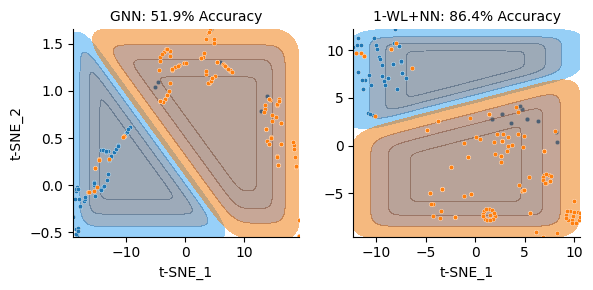

In [34]:
def custom_plotter(data, x, y, **kwargs):
    sns.kdeplot(data=data[data['scatter'] == 0], x=x, y=y, levels=5, alpha=0.5, fill=True, thresh=0.1, **kwargs)
    sns.scatterplot(data=data[data['scatter'] == 1], x=x, y=y, s=10, **kwargs)

g = sns.FacetGrid(df_svm, col='model_type', hue='class', margin_titles=True, sharex=False, sharey=False)
g.map_dataframe(custom_plotter, x='x', y='y')

g.set_titles(col_template="{col_name}", row_template="{row_name}")
#g.add_legend(title='Class Label', frameon=True, ncol=2)
g.set_axis_labels(f't-SNE_1', f't-SNE_2')

x_min_gnn, y_min_gnn = df_svm[df_svm['model_type'] == gnn_name][['x', 'y']].min()
x_max_gnn, y_max_gnn = df_svm[df_svm['model_type'] == gnn_name][['x', 'y']].max()

g.axes[0, 0].set_xlim(x_min_gnn, x_max_gnn)
g.axes[0, 0].set_ylim(y_min_gnn, y_max_gnn)

x_min_wlnn, y_min_wlnn = df_svm[df_svm['model_type'] == wlnn_name][['x', 'y']].min()
x_max_wlnn, y_max_wlnn = df_svm[df_svm['model_type'] == wlnn_name][['x', 'y']].max()
g.axes[0, 1].set_xlim(x_min_wlnn, x_max_wlnn)
g.axes[0, 1].set_ylim(y_min_wlnn, y_max_wlnn)

#g.savefig(f'../LaTeX/figures/tsne_svm_lin_{dataset_name}.pdf', bbox_inches='tight')

# Quantil

In [45]:
x = [[1, 2], [5, 2], [10, 8], [50, 3]]
data = pd.DataFrame(x, columns=['q', 'res'])

In [123]:
def calc_quantil_performance(dataframe, grouping_columns, quantils):
    rows = []

    for (grouping_values, grouped_dataframe) in dataframe.groupby(grouping_columns):
        for q in quantils:
            index = grouped_dataframe.index[grouped_dataframe['test_accuracy'] >= grouped_dataframe['test_accuracy'].quantile(1 - q, interpolation='lower')]
            grouping_info = {column: value for column, value in zip(grouping_columns, grouping_values)}
            
            for i in index:
                rows.append({'Quantile' : f'{int(q*100)}%', 'train_accuracy' : dataframe.loc[i]['train_accuracy'],
                             'val_accuracy' : dataframe.loc[i]['val_accuracy'], 'test_accuracy' : dataframe.loc[i]['test_accuracy'],
                            } | grouping_info)

    return pd.DataFrame(rows)

In [124]:
df_qunatil = calc_quantil_performance(runs_df, ['dataset', 'model_type'], quantils=[0.01, 0.05, 0.10, 0.25, 0.5, 1.0])
df_qunatil['difference'] = df_qunatil['train_accuracy'] - df_qunatil['test_accuracy']

/var/folders/gk/0jn5z2112g5b638tcpy_xs980000gn/T/ipykernel_1709/3835903218.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([f'{int(y) if y.is_integer() else y}%' for y in ax.get_yticks()])


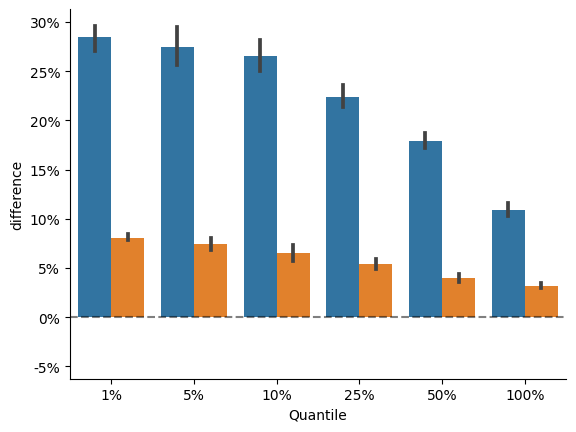

/var/folders/gk/0jn5z2112g5b638tcpy_xs980000gn/T/ipykernel_1709/3835903218.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([f'{int(y) if y.is_integer() else y}%' for y in ax.get_yticks()])


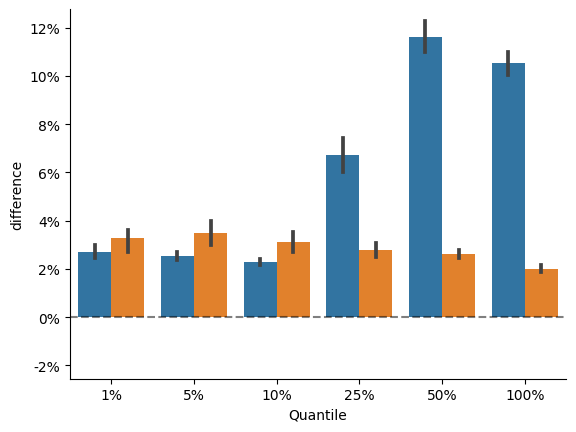

/var/folders/gk/0jn5z2112g5b638tcpy_xs980000gn/T/ipykernel_1709/3835903218.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([f'{int(y) if y.is_integer() else y}%' for y in ax.get_yticks()])


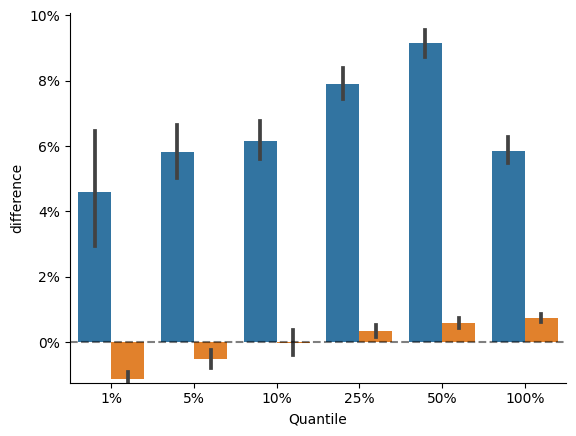

/var/folders/gk/0jn5z2112g5b638tcpy_xs980000gn/T/ipykernel_1709/3835903218.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([f'{int(y) if y.is_integer() else y}%' for y in ax.get_yticks()])


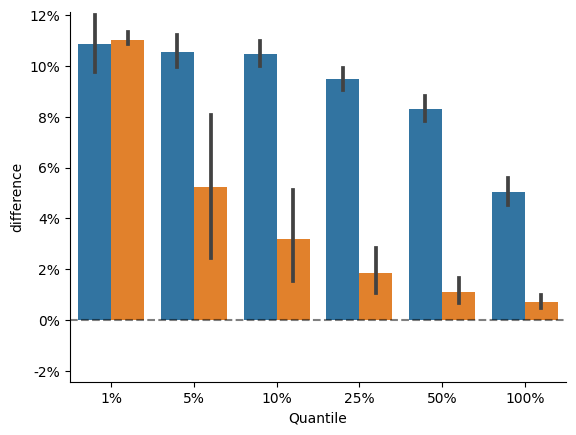

/var/folders/gk/0jn5z2112g5b638tcpy_xs980000gn/T/ipykernel_1709/3835903218.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([f'{int(y) if y.is_integer() else y}%' for y in ax.get_yticks()])


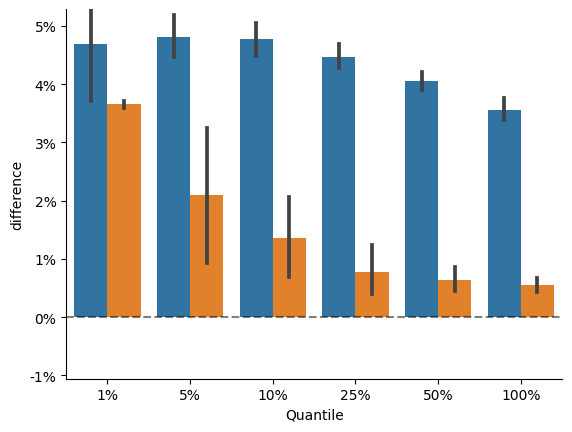

/var/folders/gk/0jn5z2112g5b638tcpy_xs980000gn/T/ipykernel_1709/3835903218.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([f'{int(y) if y.is_integer() else y}%' for y in ax.get_yticks()])


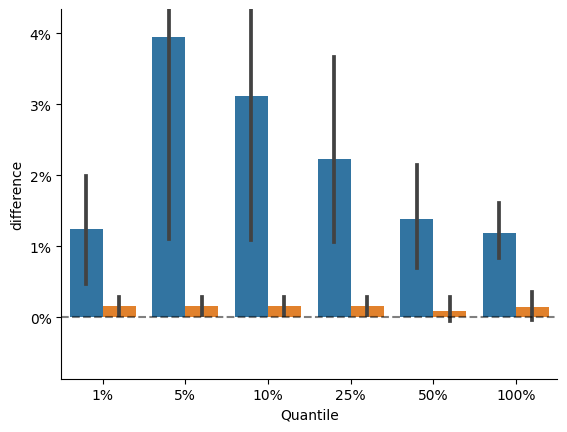

In [152]:
for dataset_name in df_qunatil['dataset'].unique():
    df = df_qunatil[df_qunatil['dataset'] == dataset_name]

    ax = sns.barplot(df, x='Quantile', y='difference', hue='model_type', hue_order=['1-WL+NN', 'GNN'], estimator='mean')
    sns.despine(bottom = False, left = False)

    #bar.set_title('Absolute Difference in Classification Accuracies between Training and Testing')


    y_max = df[['difference', 'Quantile', 'model_type']].groupby(['Quantile', 'model_type']).mean().max().abs().item()
    y_min = df[['difference', 'Quantile', 'model_type']].groupby(['Quantile', 'model_type']).mean().min().item()

    if y_min > 0:
        y_min = - 0.2 * y_max

    ax.set_ylim([1.1* y_min, 1.1 * y_max])

    ax.set_yticklabels([f'{int(y) if y.is_integer() else y}%' for y in ax.get_yticks()])

    ax.axhline(0.0, color='black', linestyle='--', alpha=0.5, snap=True)
    ax.legend_.remove()

    fig = ax.get_figure()
    #fig.savefig(f'../LaTeX/figures/train_test_diff_{dataset_name}.pdf', bbox_inches='tight')

    plt.show()

In [159]:
import pylab

fig = pylab.figure()

figlegend = pylab.figure(figsize=(3,2))
figlegend.legend(ax.get_legend_handles_labels()[0], ax.get_legend_handles_labels()[1], ncol=2)
figlegend.show()
figlegend.savefig(f'../LaTeX/figures/train_test_diff_legend.pdf', bbox_inches='tight')


/var/folders/gk/0jn5z2112g5b638tcpy_xs980000gn/T/ipykernel_1709/211676164.py:7: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  figlegend.show()


<Figure size 640x480 with 0 Axes>

<Figure size 300x200 with 0 Axes>